In [1]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

ee.Initialize()
print("Earth Engine initialized successfully.")

Earth Engine initialized successfully.


Define bounding boxes for all cities (Kabul, Herat, Mazar, Kandahar, Jalalabad)

In [6]:
# define the helpfer function that makes bounding box from lat lon
def make_city_bbox(lon, lat, half_deg=0.25):
    """Create a bounding box around a city center.
    half_deg ~ 0.25 degrees = ~25-30 km in each direction
    """
    return ee.Geometry.Rectangle([
        lon - half_deg,
        lat - half_deg,
        lon + half_deg,
        lat + half_deg,
    ])

In [7]:
# approximate city centers (lat, lon)
CITIES = {
    "Kabul": {"lat": 34.5553, "lon": 69.2075},
    "Herat": {"lat": 34.3529, "lon": 62.2040},
    "Mazar": {"lat": 36.7090, "lon": 67.1109},
    "Kandahar": {"lat": 31.6289, "lon": 65.7372},
    "Jalalabad": {"lat": 34.4347, "lon": 70.4475}
}

# create geometry object for each city
for city, info in CITIES.items():
    info["geom"] = make_city_bbox(info["lon"], info["lat"], half_deg=0.25)

CITIES

{'Kabul': {'lat': 34.5553,
  'lon': 69.2075,
  'geom': ee.Geometry({
    "functionInvocationValue": {
      "functionName": "GeometryConstructors.Polygon",
      "arguments": {
        "coordinates": {
          "constantValue": [
            [
              [
                68.9575,
                34.8053
              ],
              [
                68.9575,
                34.3053
              ],
              [
                69.4575,
                34.3053
              ],
              [
                69.4575,
                34.8053
              ]
            ]
          ]
        },
        "evenOdd": {
          "constantValue": true
        }
      }
    }
  })},
 'Herat': {'lat': 34.3529,
  'lon': 62.204,
  'geom': ee.Geometry({
    "functionInvocationValue": {
      "functionName": "GeometryConstructors.Polygon",
      "arguments": {
        "coordinates": {
          "constantValue": [
            [
              [
                61.954,
                34.6029

In [8]:
# Define the Sentinel-5P NO2 collection once
NO2_COLLECTION = (
    ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2")
    .select("tropospheric_NO2_column_number_density")
)

In [18]:
# define the date range
start = ee.Date("2023-01-01")
end = ee.Date("2024-01-01")

In [19]:
def get_monthly_no2_for_city(city_name, geom, start_date, end_date):
    """
    Returns a pandas DataFrame with monthly mean NO2 for a single city.
    """
    # number of months between start and end
    n_months = end_date.difference(start_date, "month").int()
    month_indices = ee.List.sequence(0, n_months.subtract(1))

    def monthly_feature(m):
        """Compute monthly mean NO2 and return a Feature."""
        m = ee.Number(m)
        start_m = start_date.advance(m, "month")
        end_m   = start_m.advance(1, "month")

        monthly_coll = (
            NO2_COLLECTION
            .filterDate(start_m, end_m)
            .filterBounds(geom)
        )

        monthly_img = monthly_coll.mean()

        mean_dict = monthly_img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom,
            scale=1000,
            bestEffort=True
        )

        return ee.Feature(
            None,
            {
                "city": city_name,
                "month_start": start_m.format("YYYY-MM-dd"),
                "no2": mean_dict.get("tropospheric_NO2_column_number_density")
            }
        )

    # Map over months
    fc = ee.FeatureCollection(month_indices.map(monthly_feature))

    # Bring into Python
    data = fc.getInfo()
    rows = []
    for f in data["features"]:
        p = f["properties"]
        rows.append({
            "city": p["city"],
            "month_start": p["month_start"],
            "no2": p["no2"]
        })

    df = pd.DataFrame(rows)
    df["month_start"] = pd.to_datetime(df["month_start"])
    df = df.sort_values("month_start")
    df = df.dropna(subset=["no2"])
    return df


In [20]:
df_test = get_monthly_no2_for_city(
    city_name="Kabul",
    geom=CITIES["Kabul"]["geom"],
    start_date=start,
    end_date=end
)

df_test

,city,month_start,no2
0,Kabul,2023-01-01,0.000035
1,Kabul,2023-02-01,0.000036
2,Kabul,2023-03-01,0.000034
3,Kabul,2023-04-01,0.000035
4,Kabul,2023-05-01,0.000024
5,Kabul,2023-06-01,0.000020
6,Kabul,2023-07-01,0.000030
7,Kabul,2023-08-01,0.000033
8,Kabul,2023-09-01,0.000028
9,Kabul,2023-10-01,0.000031


In [21]:
city_dfs = []

for city_name, info in CITIES.items():
    print(f"Processing {city_name}...")
    df_city = get_monthly_no2_for_city(
        city_name=city_name,
        geom=info["geom"],
        start_date=start,
        end_date=end
    )
    city_dfs.append(df_city)

df_all = pd.concat(city_dfs, ignore_index=True)
df_all = df_all.sort_values(["city", "month_start"])
df_all.head()


Processing Kabul...
Processing Herat...
Processing Mazar...
Processing Kandahar...
Processing Jalalabad...


,city,month_start,no2
11,Herat,2023-01-01,0.000011
12,Herat,2023-02-01,0.000014
13,Herat,2023-03-01,0.000012
14,Herat,2023-04-01,0.000013
15,Herat,2023-05-01,0.000014


In [22]:
pivot = df_all.pivot(index="month_start", columns="city", values="no2")
pivot


city,Herat,Jalalabad,Kabul,Kandahar,Mazar
month_start,,,,,
2023-01-01,0.000011,0.000018,0.000035,0.000012,0.000012
2023-02-01,0.000014,0.000025,0.000036,0.000012,0.000015
2023-03-01,0.000012,0.000023,0.000034,0.000013,0.000012
2023-04-01,0.000013,0.000020,0.000035,0.000014,0.000016
2023-05-01,0.000014,0.000021,0.000024,0.000016,0.000017
2023-06-01,0.000013,0.000020,0.000020,0.000015,0.000017
2023-07-01,0.000017,0.000028,0.000030,0.000021,0.000023
2023-08-01,0.000018,0.000028,0.000033,0.000022,0.000021
2023-09-01,0.000014,0.000023,0.000028,0.000018,0.000016


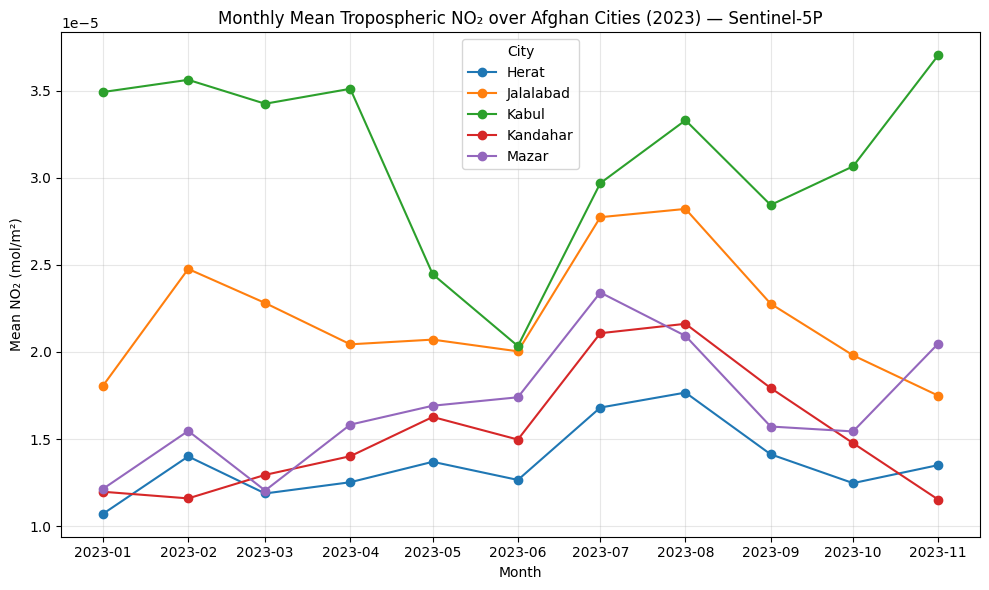

In [23]:
plt.figure(figsize=(10, 6))

for city in pivot.columns:
    plt.plot(pivot.index, pivot[city], marker="o", label=city)

plt.title("Monthly Mean Tropospheric NO₂ over Afghan Cities (2023) — Sentinel-5P")
plt.xlabel("Month")
plt.ylabel("Mean NO₂ (mol/m²)")
plt.grid(True, alpha=0.3)
plt.legend(title="City")
plt.tight_layout()
plt.show()


### Interpretation

This chart compares monthly mean tropospheric NO₂ over five Afghan cities during 2023, using Sentinel-5P OFFL/L3 NO₂ data.

We see clear seasonal patterns, with higher NO₂ levels in colder months and lower levels in warmer months. Kabul typically shows the highest NO₂ values, consistent with its dense traffic, combustion for winter heating, and basin-like topography that can trap pollutants. Other cities show lower and sometimes flatter profiles, reflecting differences in population density, emission sources, and local meteorology.
